#  KONBRIEFING.


## Importación de librerías.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re
from urllib.parse import urlparse
import os
import json
from sklearn.metrics import silhouette_score, silhouette_samples
# === Configuración de colores ===
denexus_colors = ['#1B2D40', '#577596', '#C7262B', '#F85C37', '#FF8250', '#4A4A4A']
denexus_palette = sns.light_palette("#1B2D40", n_colors=100, as_cmap=True)

## Importación e información del Dataframe.

In [2]:
df = pd.read_csv("data/KONBRIEFING.csv")

In [3]:
df.head()

,date,title,description,references,date_uploaded
0,April 2024,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria","[{""title"":""Hackerangriff auf Facebookseite der...",2024-04-29
1,"April 25, 2024",Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...","[{""title"":""Cyberangriff auf Max Wild GmbH"",""ur...",2024-04-29
2,"April 25, 2024",Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...","[{""title"":""Notre ville est actuellement victim...",2024-04-29
3,"April 25, 2024",Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...","[{""title"":""KC Scout Alert"",""url"":""https://www....",2024-04-29
4,"April 24, 2024",Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium","[{""title"":""Stadsdiensten van Deinze geplaagd d...",2024-04-29


In [4]:
df.columns

Index(['date', 'title', 'description', 'references', 'date_uploaded'], dtype='object')

A continuación, se incluye una breve explicación sobre la información que aporta cada columna.
- **Date**: Fecha del ataque (aunque algunos valores están incompletos).
- **Title**: Título del incidente.
- **Description**: Descripción del incidente, que puede incluir la víctima o el sector.
- **References**: Fuentes de referencia para el incidente.
- **Date Uploaded**: Fecha de subida del incidente al sistema.

In [5]:
df.describe(include='all')

,date,title,description,references,date_uploaded
count,67310,67326,67358,67358,67358
unique,1129,4027,4030,4053,16
top,"May 31, 2023",Cyber attack on a university of applied scienc...,? - USA,[],2024-04-29
freq,6624,218,1296,2803,4392


In [6]:
df.dtypes

date             object
title            object
description      object
references       object
date_uploaded    object
dtype: object

## Limpieza de datos.
En un análisis de ciberseguridad, las columnas más importantes son **Date** (fecha del ataque), **Title** (título del incidente) y **Description** (descripción del ataque), ya que proporcionan la información necesaria para identificar patrones temporales, tipos de ataques y sectores afectados. Estas son fundamentales para estudios sobre tendencias, como el aumento de incidentes en ciertos periodos o vulnerabilidades en sectores específicos. Por otro lado, las columnas **Date uploaded** y **References** son menos relevantes para el análisis de patrones, ya que solo indican cuándo se documentó el incidente y las fuentes, aunque pueden ser útiles para validar la información.

In [7]:
df.drop(columns=['date_uploaded'], inplace=True)

El proceso consiste en convertir las cadenas de la columna, que pueden representar listas de diccionarios, en estructuras adecuadas para extraer la información relevante.

Primero, las cadenas se convierten en listas de diccionarios, manejando posibles errores de formato mediante excepciones para evitar fallos. Cuando la conversión es exitosa, se extraen los valores de las claves `title` y `url` de los diccionarios dentro de la lista, asignando valores predeterminados como `None` si no se encuentran datos. Esto permite crear dos nuevas columnas: **References title** y **References URL**.

### Manejo de filas duplicadas.
En caso de haber filas duplicadas, deberemos de eliminar estas para que no afecten al análisis posterior.

In [8]:
df.duplicated().sum() # Columnas duplicadas

62970

Los duplicados en el conjunto de datos representan registros que contienen información redundante o repetitiva, lo que puede sesgar los análisis y afectar la calidad de un modelo de Machine Learning. En este caso, se consideran duplicados aquellos registros que comparten el mismo título, descripción y referencias, ya que estas columnas capturan la esencia del contenido del dato. La columna **Date Uploaded**, que refleja el momento en que los datos fueron cargados al sistema, no será relevante para definir duplicados porque no aporta información directa sobre los ciberataques en sí. Al eliminar los duplicados, aseguramos que el modelo trabaje con datos únicos y representativos, evitando sesgos y optimizando la eficiencia del análisis.

In [9]:
df.drop_duplicates(inplace = True)

In [10]:
df.shape

(4388, 4)

### Manejo de filas nulas.

In [11]:
df.isnull().sum()

date           3
title          2
description    0
references     0
dtype: int64

In [12]:
df.dropna(inplace=True)

### Selección de variables categóricas y continuas.
Para realizar correctamente un ánalisis de datos debemos de distinguir entre las variables categóricas, variables que representan diferentes categorías o grupos, y continuas, variables que pueden tomar cualquier valor dentro de un rango determinado.

In [13]:
v_continuas = []
v_categoricas = []
for i in df.columns:
    if df[i].nunique() > 70 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: date, title, description, references
Variables categóricas: 


#### Tratamiento de variables continuas.
Para el modelo de clasificación debemos de pasar todas las columnas a tipo `int`. Por ello, debemos de ver si realizar como en el caso anterior una codificación ordinal o agruparlos.

##### **Date.**

In [14]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [15]:
df.isnull().sum()

date           199
title            0
description      0
references       0
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [18]:
df.head()

,date,title,description,references,year,month,day
0,2024-04-01,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria","[{""title"":""Hackerangriff auf Facebookseite der...",2024,4,1
1,2024-04-25,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...","[{""title"":""Cyberangriff auf Max Wild GmbH"",""ur...",2024,4,25
2,2024-04-25,Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...","[{""title"":""Notre ville est actuellement victim...",2024,4,25
3,2024-04-25,Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...","[{""title"":""KC Scout Alert"",""url"":""https://www....",2024,4,25
4,2024-04-24,Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium","[{""title"":""Stadsdiensten van Deinze geplaagd d...",2024,4,24


In [19]:
df.drop(columns=['date'], inplace=True)

##### **Title.**


In [20]:
df['title'].unique()

array(['Facebook page of the local branch of a political party in Austria hacked',
       'Cyber attack on a construction company in Germany',
       'Cyber attack on a city government in France', ...,
       'DDoS attack on the website of a airport in India',
       'DDoS attack on the website of a airport in Italy',
       'Cyber attack on a airport authority in Kenya'], dtype=object)

In [21]:
attack_types = {
    'Ransomware': [
        'ransomware', 'encrypt', 'extortion', 'decrypt', 'crypto', 'bitcoin', 'locker', 'ransomed', 'payment demanded', 'locked'
    ],
    'Phishing': [
        'phishing', 'social engineering', 'fraud', 'scammed', 'deceptive', 'trick', 'email', 'fake', 'impersonation', 'fake login'
    ],
    'Data breach': [
        'data breach', 'data theft', 'stolen', 'leak', 'exposure', 'transfer', 'sold', 'darknet', 'taxpayers', 'compromised', 'database'
    ],
    'Hacking': [
        'hacked', 'hackers', 'gained access', 'unauthorized', 'breach', 'penetration', 'cyber attack', 'system breach'
    ],
    'Malware': [
        'malware', 'spyware', 'virus', 'trojan', 'adware', 'keylogger', 'infected', 'software hacked', 'IT system', 'malicious'
    ],
    'Ddos': [
        'ddos', 'denial of service', 'botnet', 'traffic overload', 'flood', 'outage', 'network disruption', 'traffic spike'
    ],
    'Cyber incident': [
        'incident', 'affected', 'attack', 'compromised', 'sector', 'municipality', 'region', 'library', 'operator'
    ]
}


In [22]:
def classify_attack(title):
    for attack, keywords in attack_types.items():
        for keyword in keywords:
            if re.search(keyword, title, re.IGNORECASE):
                return attack
    return 'Unknown'

In [23]:
df['attack_type'] = df['title'].apply(classify_attack)
df['attack_type'].value_counts()

Hacking           2330
Ransomware         553
Cyber incident     550
Ddos               414
Data breach        128
Phishing            99
Unknown             62
Malware             48
Name: attack_type, dtype: int64

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [24]:
columns = df.columns.tolist()
index = columns.index('title')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [25]:
encoder = LabelEncoder()
df['attack_type_code'] = encoder.fit_transform(df['attack_type'])

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [26]:
columns = df.columns.tolist()
index = columns.index('attack_type')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [27]:
df.head(3)

,title,attack_type,attack_type_code,description,references,year,month,day
0,Facebook page of the local branch of a politic...,Hacking,3,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria","[{""title"":""Hackerangriff auf Facebookseite der...",2024,4,1
1,Cyber attack on a construction company in Germany,Hacking,3,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...","[{""title"":""Cyberangriff auf Max Wild GmbH"",""ur...",2024,4,25
2,Cyber attack on a city government in France,Hacking,3,"Ville de Gravelines - Gravelines, Hauts-de-Fra...","[{""title"":""Notre ville est actuellement victim...",2024,4,25


##### **Description.**
La columna **Description** contiene información clave sobre el lugar donde ocurrió el incidente, proporcionando un contexto geográfico valioso para el análisis. Este dato se puede aprovechar clasificando cada registro según el continente al que pertenece la ubicación de la víctima. Identificar los continentes nos permitirá segmentar los datos de manera más eficiente, ayudando a detectar patrones regionales de ciberataques y sus posibles tendencias.

In [28]:
df['description'].unique()

array(['SPÖ Müllendorf - Müllendorf, Burgenland, Austria',
       'Max Wild GmbH - Berkheim, Baden-Württemberg, Germany (Landkreis Biberach)',
       'Ville de Gravelines - Gravelines, Hauts-de-France, France', ...,
       'Universitat Oberta de Catalunya (UOC) - Barcelona, Catalonia, Spain',
       'Llucmajor, Islas Baleares, Spain',
       'Katholische Kirche Nordharz - Goslar, Lower Saxony, Germany'],
      dtype=object)

In [29]:
df['country'] = df['description'].apply(lambda x: x.split(',')[-1].strip() if isinstance(x, str) else None)

df['country'].unique()[:10]

array(['Austria', 'Germany (Landkreis Biberach)', 'France',
       'Platte County)', 'Belgium', 'Argentina', 'Canada',
       'České noviny (ČN) / Česká tisková kancelář (ČTK) - Czech Republik',
       'Skanlog - Sweden', 'Germany (Landkreis Unterallgäu)'],
      dtype=object)

In [30]:
def clean_country_name(country):
  if '-' in country:
    cleaned_name = country.split('-')[-1].strip()
  else:
    cleaned_name = re.sub(r"\(.*?\)", "", country).strip()
  return cleaned_name.strip()

df['country'] = df['country'].apply(clean_country_name)

In [31]:
df['country'] = df['country'].str.replace(r'\)', '', regex=True)

In [32]:
df['country'].unique()[:10]

array(['Austria', 'Germany', 'France', 'Platte County', 'Belgium',
       'Argentina', 'Canada', 'Czech Republik', 'Sweden', 'Mexico'],
      dtype=object)

In [33]:
continents_mapping = {
    'Africa': [
        'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic',
        'Chad', 'Comoros', 'Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon',
        'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar',
        'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
        'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan',
        'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe', 'Libya / ليبيا'
    ],
    'Asia': [
        'Afghanistan', 'Armenia', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia', 'China', 'Cyprus',
        'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan',
        'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'North Korea', 'Oman', 'Pakistan',
        'Palestine', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Taiwan',
        'Tajikistan', 'Thailand', 'Timor-Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen',
        "People's Republic of China", 'Republic of China / Taiwan', 'Jordanien / الأردن', 'Malediven / ދިވެހިރާއްޖޭގެ ޖުމްހޫރިއްޔާ'
    ],
    'Europe': [
        'Albania', 'Andorra', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria',
        'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece',
        'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta',
        'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
        'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom',
        'Vatican City', 'Czech Republik', 'Upper Austria', 'Kingdom of the Netherlands', 'Serbien / Србија', 'UK', 'Isle of Man',
        'Vatican', 'Rügen', 'Kreis', 'Schrobenhausen', 'Frankreich', 'Lübbecke', 'Meiningen', 'Bogen', 'Wittgenstein',
        'Zell', 'Ulm', 'Kreis Neuss', 'Koblenz', 'Neckar district', 'Weilburg', 'Grafenau', 'Greifswald', 'Gunzenhausen',
        'Bitterfeld district', 'Bingen district', 'Frankenberg', 'Spessart', 'Jersey', 'Osterzgebirge', 'Hochschwarzwald',
        'Germany ', 'Höchstadt', 'Guernsey', 'Europe', 'Worms', 'Harmony', 'Poly Network', 'PolyNetwork', 'Wormhole'
    ],
    'North America': [
        'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic',
        'El Salvador', 'Grenada', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama',
        'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States of America (USA)',
        'USA', 'Grönland', 'Puerto Rico', 'Bermuda', 'United States of America', 'Platte County', 'Rockwall County', 'Leelanau County', 'Lehigh County', 'Columbus County', 'DuPage County',
        'DeKalb County', 'Manatee County', 'Miami County', 'Montgomery County', 'Cook County', 'Hawkins County',
        'Williamson County', 'Utah County', 'Rankin County', 'Dade County', 'Roane County', 'Chester County', 'Callaway Country',
        'Howard County', 'Clinton County', 'Marion County', 'Durham County', 'Warren County', 'Peach County', 'Kanawha County',
        'Lexington County', 'Allegan County', 'Sint Maarten', 'Fairfield County', 'Baltimore County', 'Baltimore City', 'Baltimore', 'Bossier Parish',
        'Nicollet County'
    ],
    'South America': [
        'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'
    ],
    'Australia': [
        'Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea',
        'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu', 'Oceania'
    ],
    'Africa, Asia, North America, Europe, South America, Australia': ['Global']
}

In [34]:
def assign_continent(country_clean):
  continents = set()

  for continent, countries_list in continents_mapping.items():
    if country_clean in countries_list:
      continents.add(continent)
  return ', '.join(continents) if continents else None

df['continent'] = df['country'].apply(assign_continent)

In [35]:
countries_with_no_continent = df[df['continent'].isnull()]['country'].unique()

# Mostrar la lista de países con 'continent' como None
print("Lista de países con 'continent' como None:")
print(countries_with_no_continent)


Lista de países con 'continent' como None:
['Apex Legends Global Series' 'Pyrmont' 'Pottawatomie' 'KyberSwap'
 'Unibot' 'HTX / Huobi' 'Remitano' 'CoinEx' 'Cloudflare' 'Zunami Protocol'
 'Curve Stablecoin' 'NATO' 'Alphapo' 'Era Lend' 'CoinsPaid'
 'Archive of Our Own' 'Sturdy Finance'
 'Vulnerabilities: Progress Software MOVEit Transfer'
 '0558 targeting of customer email\r\nhttps://msrc.microsoft.com/blog/2023/07/...'
 'KuCoin' 'Kodi' 'Allbridge' 'Poolz' 'Algorand MyAlgo' 'Platypus' 'Azuki'
 'Legacy of War Foundation' 'gb/games/fifa/fifa...' 'Qubit Finance'
 'Compromised accounts of Ukrainian military personnel are being used to attack European government officials involved with refugees from Ukraine.'
 'Trickbot' 'DEUS Finance' 'Ola Finance' 'Bored Ape Yacht Club'
 'Inverse Finance' 'Beanstalk Farms' 'ZEED'
 'How Google Cloud blocked the largest Layer 7 DDoS attack at 46 million rps\r\nhttps://cloud.google.com/blog/products/i...'
 'Crema Finance'
 '399 address that have been sent a mal

In [36]:
df['continent'].isnull().sum()

66

In [37]:
df.dropna(subset=['continent'], inplace=True)

In [38]:
df_continentes = pd.get_dummies(df['continent'])
df = pd.concat([df, df_continentes], axis=1)

In [39]:
df.drop(['country', 'continent'], axis = 1, inplace = True)

In [40]:
df.head(2)

,title,attack_type,attack_type_code,description,references,year,month,day,Africa,Asia,Australia,Europe,North America,South America
0,Facebook page of the local branch of a politic...,Hacking,3,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria","[{""title"":""Hackerangriff auf Facebookseite der...",2024,4,1,0,0,0,1,0,0
1,Cyber attack on a construction company in Germany,Hacking,3,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...","[{""title"":""Cyberangriff auf Max Wild GmbH"",""ur...",2024,4,25,0,0,0,1,0,0


##### **References.**
El proceso consiste en convertir las cadenas de la columna, que pueden representar listas de diccionarios, en estructuras adecuadas para extraer la información relevante.

Primero, las cadenas se convierten en listas de diccionarios, manejando posibles errores de formato mediante excepciones para evitar fallos. Cuando la conversión es exitosa, se extraen los valores de las claves `title` y `url` de los diccionarios dentro de la lista. Esto permite crear dos nuevas columnas: **References title** y **References URL**.

In [41]:
def extract_title_url(reference_column):
    titles, urls = [], []
    for ref in reference_column:
        if not ref:
            titles.append("")
            urls.append("")
            continue
        try:
            ref_json = json.loads(ref)
            if isinstance(ref_json, list) and len(ref_json) > 0:
                first_ref = ref_json[0]
                title = first_ref.get("title", "")
                url = first_ref.get("url", "")
                site_name = urlparse(url).netloc.replace('www.', '') if url else ""
                titles.append(title)
                urls.append(site_name)
            else:
                titles.append("")
                urls.append("")
        except (json.JSONDecodeError, IndexError, TypeError) as e:
            titles.append("")
            urls.append("")

    return titles, urls

In [42]:
df['reference_title'], df['reference_url'] = extract_title_url(df['references'])
df.head(2)

,title,attack_type,attack_type_code,description,references,year,month,day,Africa,Asia,Australia,Europe,North America,South America,reference_title,reference_url
0,Facebook page of the local branch of a politic...,Hacking,3,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria","[{""title"":""Hackerangriff auf Facebookseite der...",2024,4,1,0,0,0,1,0,0,Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at
1,Cyber attack on a construction company in Germany,Hacking,3,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...","[{""title"":""Cyberangriff auf Max Wild GmbH"",""ur...",2024,4,25,0,0,0,1,0,0,Cyberangriff auf Max Wild GmbH,maxwild.com


In [43]:
df.drop(columns=['references'], inplace=True)

In [44]:
df = df[(df['reference_title'].notnull()) & (df['reference_title'] != '') &
                (df['reference_url'].notnull()) & (df['reference_url'] != '')]

**Reference Title.**

In [45]:
df['reference_title'].unique()

array(['Hackerangriff auf Facebookseite der SPÖ Müllendorf',
       'Cyberangriff auf Max Wild GmbH',
       'Notre ville est actuellement victime d’une cyber-attaque.', ...,
       'Cancer & Hematology Centers of Western Michigan, P.C. Notifies Individuals of Data Security Incident Involving Personal Information',
       'Internet restored after cyber attack against Rowan-Salisbury Schools',
       'Ciberataque contra la Universitat Oberta de Catalunya'],
      dtype=object)

**Reference URL.**

In [46]:
df['reference_url'].unique()

array(['meinbezirk.at', 'maxwild.com', 'facebook.com', ..., 'npr.org',
       'chcwm.com', 'salisburypost.com'], dtype=object)

In [47]:
df.head(2)

,title,attack_type,attack_type_code,description,year,month,day,Africa,Asia,Australia,Europe,North America,South America,reference_title,reference_url
0,Facebook page of the local branch of a politic...,Hacking,3,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",2024,4,1,0,0,0,1,0,0,Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at
1,Cyber attack on a construction company in Germany,Hacking,3,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",2024,4,25,0,0,0,1,0,0,Cyberangriff auf Max Wild GmbH,maxwild.com


In [48]:
df.to_csv('./data/KONBRIEFING_cleaned.csv', index=False)

## Modelos de clasificación.

In [49]:
df_1 = df.drop(list(df.select_dtypes(include=['object']).columns), axis = 1)

In [50]:
df_1.dtypes

attack_type_code    int32
year                int64
month               int64
day                 int64
Africa              uint8
Asia                uint8
Australia           uint8
Europe              uint8
North America       uint8
South America       uint8
dtype: object

### Modelos de Clasificación Supervisado.
En este caso, no resulta adecuado realizar modelos supervisados, ya que las columnas disponibles no ofrecen suficiente información relevante para predecir ciberataques. Además, no se cuenta con una variable objetivo (target) clara que permita entrenar un modelo. Sin la cantidad y calidad de datos necesarios, los métodos supervisados no serían útiles ni ofrecerían resultados fiables.

#### Matriz de correlación.

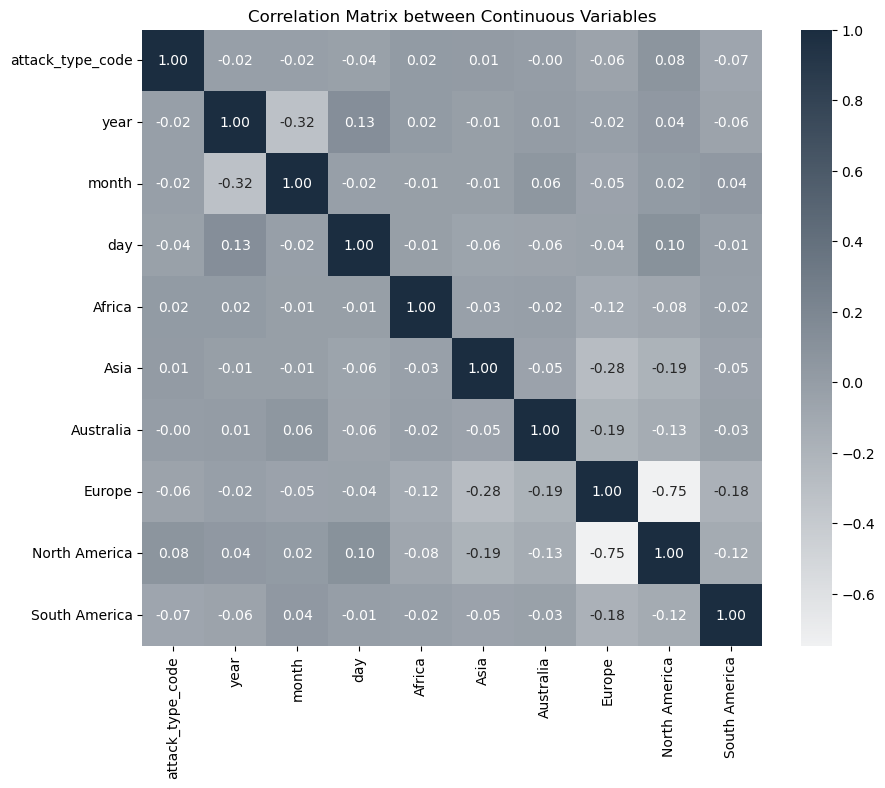

In [51]:
correlation_matrix = df_1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=denexus_palette, fmt=".2f")
plt.title('Correlation Matrix between Continuous Variables')
plt.show()

### Modelos de Clasificación No Supervisado.
Aplicamos el modelo no supervisado K-Means para agrupar los datos en los clusters indicados a través del **método Elbow**, utilizando las características del conjunto de entrenamiento. Finalmente, se genera un resumen de las medias de las características por cada cluster para su análisis.

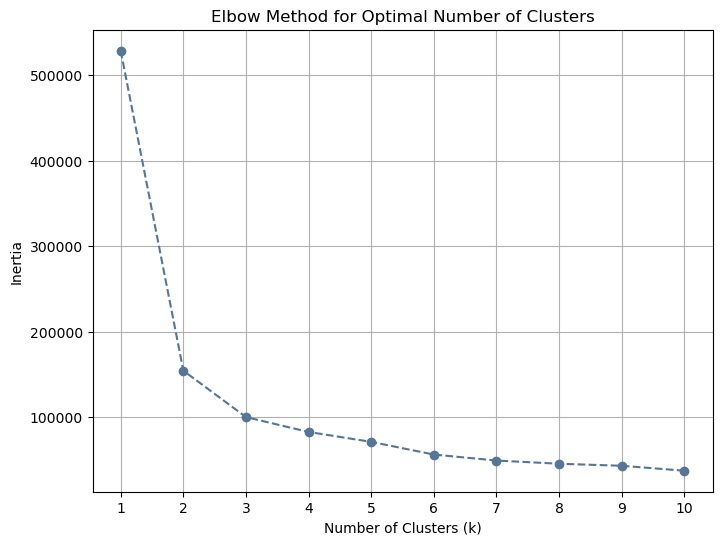

In [52]:
#Elbow method.
X_unsupervised = df_1.copy()
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_unsupervised)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color=denexus_colors[1])
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "elbow-method-kmeans.png")
    plt.savefig(output_path)
plt.show()

In [53]:
for k, score in zip(range(1, 11), inertia):
    print(f"Number of Clusters (k={k}): Inertia = {score:.4f}")

Number of Clusters (k=1): Inertia = 528322.6598
Number of Clusters (k=2): Inertia = 154505.4309
Number of Clusters (k=3): Inertia = 100307.1235
Number of Clusters (k=4): Inertia = 82892.5020
Number of Clusters (k=5): Inertia = 71338.9143
Number of Clusters (k=6): Inertia = 56512.5201
Number of Clusters (k=7): Inertia = 49528.5117
Number of Clusters (k=8): Inertia = 45767.5746
Number of Clusters (k=9): Inertia = 43397.6036
Number of Clusters (k=10): Inertia = 37620.6010


In [54]:
#KMeans.
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_unsupervised)

KMeans(n_clusters=6, random_state=42)

In [55]:
X_unsupervised['Cluster'] = kmeans.predict(X_unsupervised)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Inertia for optimal_k ({optimal_k}): {kmeans.inertia_:.4f}")

Optimal number of clusters: 6
Inertia for optimal_k (6): 56512.5201


Optimal number of clusters: 6
Inertia for optimal_k (6): 56512.5201
Silhouette Score (Average): 0.4177


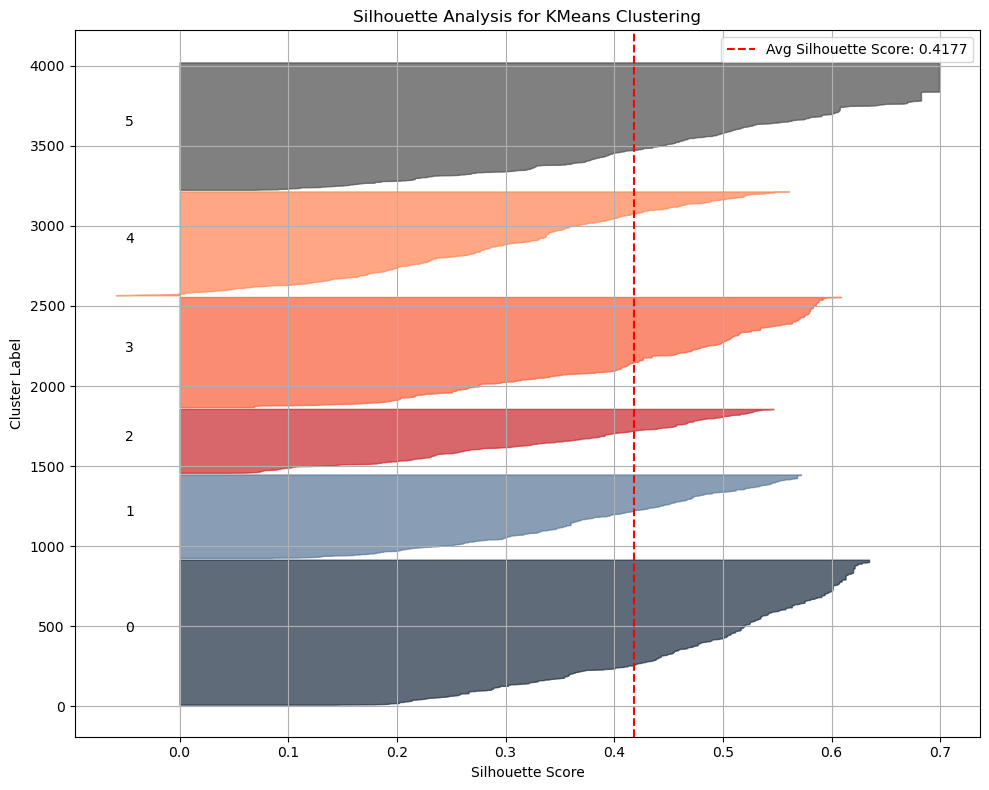

In [56]:
silhouette_avg = silhouette_score(X_unsupervised, X_unsupervised['Cluster'])
silhouette_values = silhouette_samples(X_unsupervised, X_unsupervised['Cluster'])

print(f"Optimal number of clusters: {optimal_k}")
print(f"Inertia for optimal_k ({optimal_k}): {kmeans.inertia_:.4f}")
print(f"Silhouette Score (Average): {silhouette_avg:.4f}")

# Gráfico de silueta
plt.figure(figsize=(10, 8))
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_values = silhouette_values[X_unsupervised['Cluster'] == i]
    cluster_silhouette_values.sort()
    cluster_size = len(cluster_silhouette_values)
    y_upper = y_lower + cluster_size
    
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_values,
        alpha=0.7,
        color=denexus_colors[i % len(denexus_colors)]
    )
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10  # Espacio entre clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Avg Silhouette Score: {silhouette_avg:.4f}")
plt.title("Silhouette Analysis for KMeans Clustering")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster Label")
plt.legend()
plt.grid()
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "silhouette-analysis-kmeans-cluster.png")
    plt.savefig(output_path)
plt.show()

## Gráficas generales.

### Evolución temporal de los ataques a la ciberseguridad.

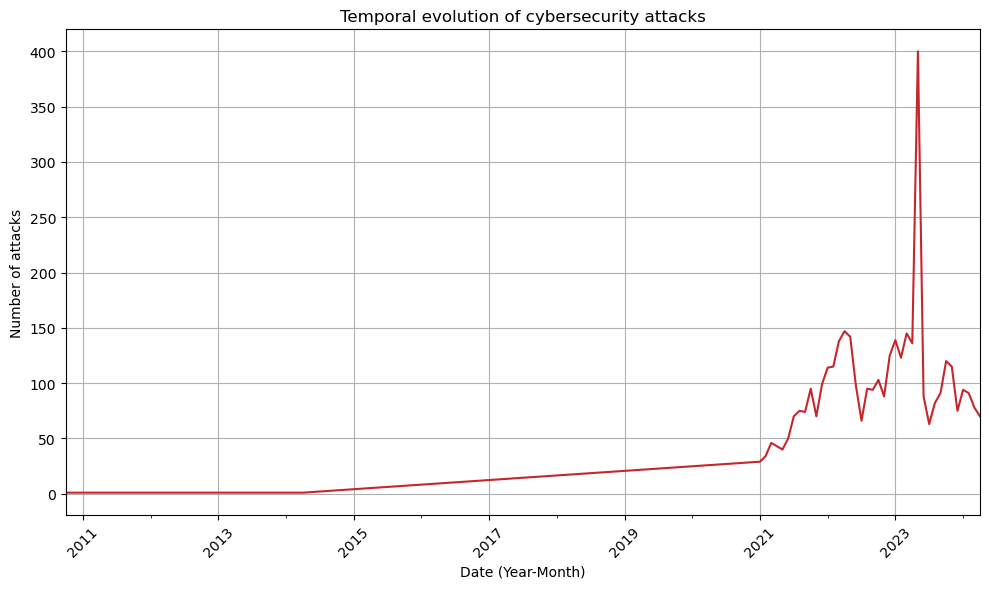

In [57]:
month_year = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2), format='%Y-%m').dt.to_period('M')
temporal_analysis = month_year.value_counts().sort_index()

plt.figure(figsize=(10, 6))
temporal_analysis.plot(kind='line', color=denexus_colors[2])
plt.title('Temporal evolution of cybersecurity attacks')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Number of attacks')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

#Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "temporal-evolution-cybersecurity-attacks.png")
plt.savefig(output_path)

### Ciberataques al mes.

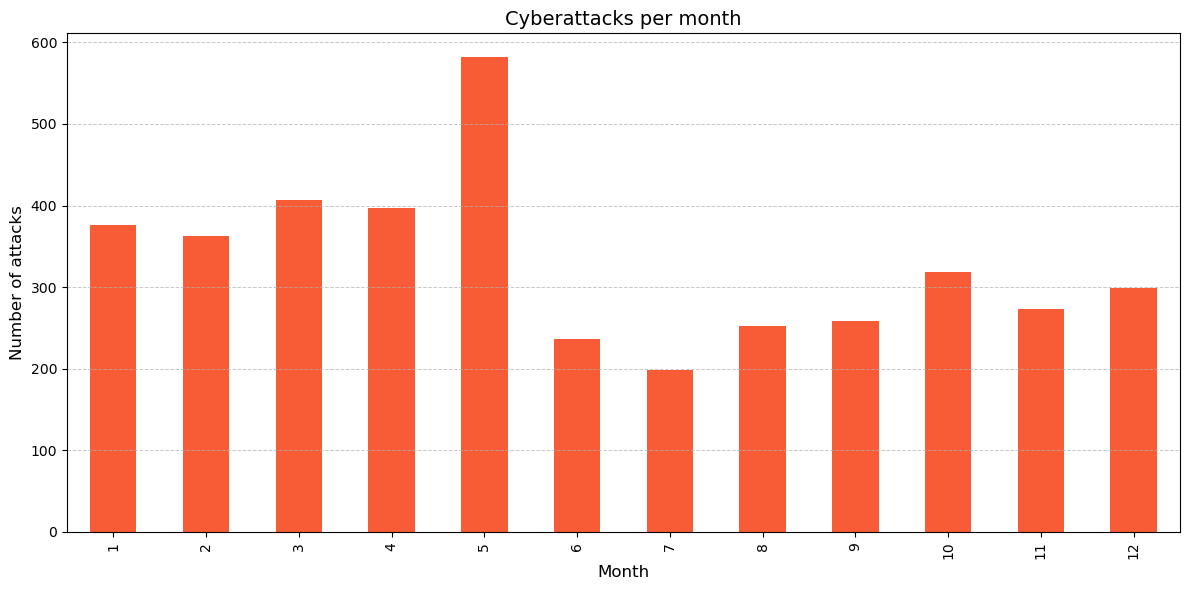

In [59]:
attacks_per_month = df['month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
attacks_per_month.plot(kind='bar', color=denexus_colors[3])
plt.title('Cyberattacks per month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of attacks', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()

# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "cyberattacks-per-month.png")
    plt.savefig(output_path)
plt.show()

### Tipos de ciberataques.

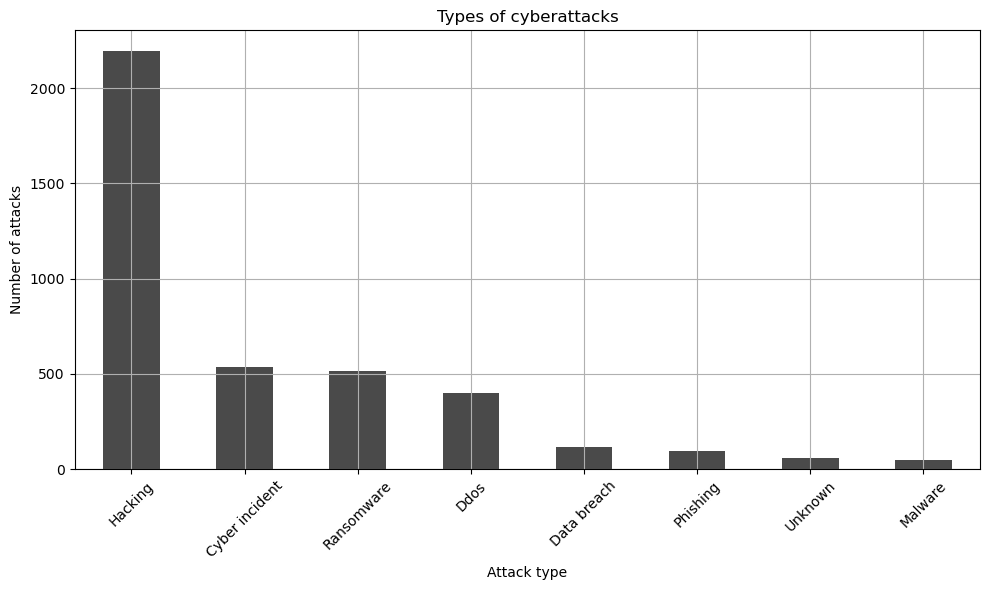

In [62]:
plt.figure(figsize=(10, 6))
df['attack_type'].value_counts().sort_values(ascending=False).plot(
    kind='bar',
    color=denexus_colors[5]
)
plt.title('Types of cyberattacks')
plt.xlabel('Attack type')
plt.ylabel('Number of attacks')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "types-of-cyberattacks.png")
    plt.savefig(output_path)
plt.show()

### Ciberataques por continente.

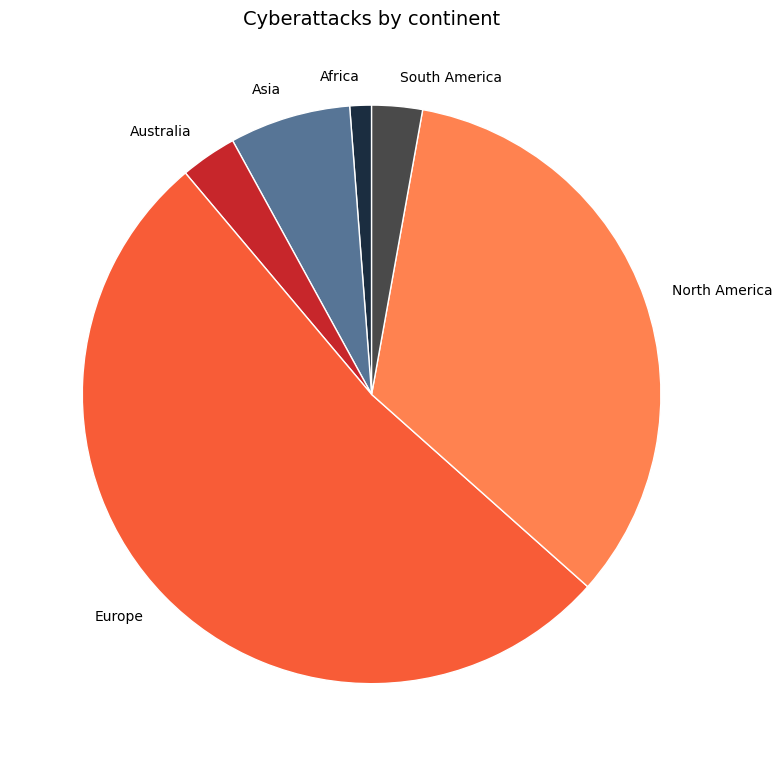

In [ ]:
continent_counts = df[['Africa', 'Asia', 'Australia', 'Europe', 'North America', 'South America']].sum()
continent_labels = continent_counts.index

plt.figure(figsize=(8, 8))
plt.pie(
    continent_counts,
    labels=continent_labels,
    colors=denexus_colors[:len(continent_counts)],
    startangle=90,
    wedgeprops={'edgecolor': 'white'},
    textprops={'fontsize': 10}
)
plt.title('Cyberattacks by continent', fontsize=14)
plt.tight_layout()

# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "cyberattacks-by-continent.png")
    plt.savefig(output_path)
plt.show()